# PDFs and consistency

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIA/SIA_PDFs_consistency.ipynb)

**Input**:
- $\sigma_{mem}$
- $\mu_{mem}$
- $\sigma_{obs}$
- $\mu_{obs}$

**Output**:
- Figure of obs and mem overlapping PDFs with percentiles
- Figure of SIA consistency between models and observations

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
import xarray as xr
import datetime

print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

17:44 UTC Mon 2022-04-11


## Load data

In [2]:
# data_path = '/glade/scratch/cwpowell/Synthetic_ensemble/'

# #sigma and mu mem
# sigma_mem = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_individual_10000.nc')
# mu_mem = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_mem_individual_10000.nc')

# #sigma and mu obs
# sigma_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_obs_individual_10000.nc')
# mu_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_obs_individual_10000.nc')

In [2]:
#load data from filtering
data_path = '/glade/scratch/cwpowell/Synthetic_ensemble_revisions/'

#sigma and mu mem
sigma_mem = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_mem_2yr_filter_10000.nc')
mu_mem = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_mem_2yr_filter_10000.nc')

#sigma and mu obs
sigma_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Sigma_obs_2yr_filter_10000.nc')
mu_obs = xr.open_dataset(data_path+'SIA/SIA_resampled/Mu_obs_2yr_filter_10000.nc')

In [3]:
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
               'August', 'September', 'October', 'November', 'December']

month_names_short = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

model_names        = ['CanESM2', 'CESM1', 'CSIRO_MK36',  'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1']
model_print_names  = ['CanESM2', 'CESM1', 'CSIRO MK3.6', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1']

mem_len   = [50,  40,  30,  20,  30,  100]

colors    = ['m', 'b', 'g', 'orange', 'k', 'tab:olive']

# PDFs

In [13]:
def percentile_text(model_i, axes_, mem, obs, obs_data_title, x_pos, y_pos):
    element = np.nanargmin(abs(np.sort(mem-obs)))
    if element == 0:
        percentile = '0'
    else:
        percentile = str(int(((element+1)/mem_len[model_i])*100))

    axes_[s_x[model_i]][s_y[model_i]].annotate(obs_data_title+' '+percentile+'%',xy=(x_pos, y_pos), xycoords='axes fraction',
                                               fontsize=12, color=colors[model_i])

In [14]:
def plot_mem_obs_distributions(month_, obs_data0, obs_data1, obs_data2, obs_data3, xlims, ylims, 
                               letter_start, all_mem=False, means=False, text=False, save_name=False, legend_true=False):
    #note means=False should only be used with all_mem=False
    fig, axes = plt.subplots(3,2,figsize=[12,8])
        
    for i, model_name in enumerate(model_names):
        sigma_mem_ = sigma_mem[model_name].sel(month=month_)
        mu_mem_  = mu_mem[model_name].sel(month=month_)
        
        sigma_obs_0 = sigma_obs[obs_data0].sel(month=month_)
        mu_obs_0 = mu_obs[obs_data0].sel(month=month_)
        
        sigma_obs_1 = sigma_obs[obs_data1].sel(month=month_)
        mu_obs_1 = mu_obs[obs_data1].sel(month=month_)
        
        sigma_obs_2 = sigma_obs[obs_data2].sel(month=month_)
        mu_obs_2 = mu_obs[obs_data2].sel(month=month_)
        
        sigma_obs_3 = sigma_obs[obs_data3].sel(month=month_)
        mu_obs_3 = mu_obs[obs_data3].sel(month=month_)
        
        ################### plot sigma_mem for all members ##################
        if all_mem:
            for mem_i in range(mem_len[i]):
                #select the correct member's data
                mu    = mu_mem_.isel(member=mem_i)
                sigma = sigma_mem_.isel(member=mem_i)
                #plot fitted line to continous 
                if means:
                    distrib_mems = stats.norm(mu, sigma)
                    x_vals_mems  = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
                else:
                    distrib_mems = stats.norm(0, sigma)
                    x_vals_mems  = np.linspace(0-5*sigma, 5*sigma, 100)
                probs_mems = [distrib_mems.pdf(x) for x in x_vals_mems]
                axes[s_x[i]][s_y[i]].plot(x_vals_mems, probs_mems, c=colors[i], linewidth=1, alpha=0.35)

        ########################## plot the MEDIAN!! sigma_mem across members ###############################
        mu    = mu_mem_.median('member')
        sigma = sigma_mem_.median('member')

        if means:
            distrib_comp = stats.norm(mu, sigma)
            x_vals_comp  = np.linspace(mu - 5*sigma, mu + 5*sigma, 100)
        else:
            distrib_comp = stats.norm(0, sigma)
            x_vals_comp  = np.linspace(0 - 5*sigma, 5*sigma, 100)
        probs_comp = [distrib_comp.pdf(x) for x in x_vals_comp]
        axes[s_x[i]][s_y[i]].plot(x_vals_comp, probs_comp, c=colors[i], linewidth=3, alpha=1,
                                  path_effects=[pe.Stroke(linewidth=6, foreground='1'), pe.Normal()])

        ############################ plot sigma_obs0 #################################
        if means:
            distrib_obs = stats.norm(mu_obs_0, sigma_obs_0)
            x_vals_obs  = np.linspace(mu_obs_0 - 5*sigma_obs_0, 
                                      mu_obs_0 + 5*sigma_obs_0, 100)
        else:
            distrib_obs = stats.norm(0, sigma_obs_0)
            x_vals_obs  = np.linspace(0 - 5*sigma_obs_0, 5*sigma_obs_0, 100)
        probs_obs = [distrib_obs.pdf(x) for x in x_vals_obs]
        axes[s_x[i]][s_y[i]].plot(x_vals_obs, probs_obs, c=(1,0,0), linestyle='-', linewidth=1.5)
        
        ############################ plot sigma_obs1 #################################
        if means:
            distrib_obs = stats.norm(mu_obs_1, sigma_obs_1)
            x_vals_obs  = np.linspace(mu_obs_1 - 5*sigma_obs_1, 
                                      mu_obs_1 + 5*sigma_obs_1, 100)
        else:
            distrib_obs = stats.norm(0, sigma_obs_1)
            x_vals_obs  = np.linspace(0 - 5*sigma_obs_1, 5*sigma_obs_1, 100)
        probs_obs = [distrib_obs.pdf(x) for x in x_vals_obs]
        axes[s_x[i]][s_y[i]].plot(x_vals_obs, probs_obs, c=(1,0,0), linestyle='--', linewidth=1.5)
        
         ############################ plot sigma_obs2 #################################
        if means:
            distrib_obs = stats.norm(mu_obs_2, sigma_obs_2)
            x_vals_obs  = np.linspace(mu_obs_2 - 5*sigma_obs_2, 
                                      mu_obs_2 + 5*sigma_obs_2, 100)
        else:
            distrib_obs = stats.norm(0, sigma_obs_2)
            x_vals_obs  = np.linspace(0 - 5*sigma_obs_2, 5*sigma_obs_2, 100)
        probs_obs = [distrib_obs.pdf(x) for x in x_vals_obs]
        axes[s_x[i]][s_y[i]].plot(x_vals_obs, probs_obs, c=(0.6,0,0), linestyle='-', linewidth=1.5)
        
         ############################ plot sigma_obs3 #################################
        if means:
            distrib_obs = stats.norm(mu_obs_3, sigma_obs_3)
            x_vals_obs  = np.linspace(mu_obs_3 - 5*sigma_obs_3, 
                                      mu_obs_3 + 5*sigma_obs_3, 100)
        else:
            distrib_obs = stats.norm(0, sigma_obs_3)
            x_vals_obs  = np.linspace(0 - 5*sigma_obs_3, 5*sigma_obs_3, 100)
        probs_obs = [distrib_obs.pdf(x) for x in x_vals_obs]
        axes[s_x[i]][s_y[i]].plot(x_vals_obs, probs_obs, c=(0.6,0,0), linestyle='--', linewidth=1.5)

        ########################### add text and title to subplot ##################################
        if text:
            axes[s_x[i]][s_y[i]].annotate(r'$\sigma$', xy=(0.03, 0.89), xycoords='axes fraction', fontsize=12, color=colors[i]);
            axes[s_x[i]][s_y[i]].annotate(r'$\mu$'+'  ', xy=(0.03, 0.79), xycoords='axes fraction', fontsize=12, color=colors[i]);
            
            percentile_text(i, axes, sigma_mem_, sigma_obs_0, obs_data0, 0.08, 0.89)
            percentile_text(i, axes, sigma_mem_, sigma_obs_1, obs_data1, 0.3,  0.89)
            percentile_text(i, axes, sigma_mem_, sigma_obs_2, obs_data2, 0.5, 0.89)
            percentile_text(i, axes, sigma_mem_, sigma_obs_3, obs_data3, 0.7,  0.89)
            
            percentile_text(i, axes, mu_mem_, mu_obs_0, obs_data0, 0.08, 0.79)
            percentile_text(i, axes, mu_mem_, mu_obs_1, obs_data1, 0.3,  0.79)
            percentile_text(i, axes, mu_mem_, mu_obs_2, obs_data2, 0.5, 0.79)
            percentile_text(i, axes, mu_mem_, mu_obs_3, obs_data3, 0.7,  0.79)

        #add title
        axes[s_x[i]][s_y[i]].set_title('({}) {}'.format(letter_list[i+letter_start], model_print_names[i]), fontsize=15)
        #add axes titles and labels
        axes[s_x[i]][s_y[i]].set_xlim(xlims[0], xlims[1])
        axes[s_x[i]][s_y[i]].set_ylim(ylims[0], ylims[1])
        
        for tick in axes[s_x[i]][s_y[i]].xaxis.get_major_ticks():
            tick.label.set_fontsize(13) 
        for tick in axes[s_x[i]][s_y[i]].yaxis.get_major_ticks():
            tick.label.set_fontsize(13) 

        if i%2 == 0:
            axes[s_x[i]][s_y[i]].set_ylabel('Normalized Frequency', fontsize=14)

        if xlab_bool[i]: axes[s_x[i]][s_y[i]].set_xlabel(r'$Standard \ Deviation \ of \ SIA \ [10^6 \ km^2]$', fontsize=14)

    
    plt.suptitle(month_names[month_-1], fontsize=18, fontweight='bold')
    
    if legend_true:
        legend_elements = [Line2D([0], [0], color=(1,0,0), ls='-', lw=2, label='CDR'),
                           Line2D([0], [0], color=(1,0,0), ls='--', lw=2, label='BT'),
                           Line2D([0], [0], color=(0.7,0,0), ls='-', lw=2, label='NT'),
                           Line2D([0], [0], color=(0.7,0,0), ls='--', lw=2, label='HadISST1'),
                           Line2D([0], [0], color=colors[0], lw=3, label='CanESM2'),
                           Line2D([0], [0], color=colors[1], lw=3, label='CESM1'),
                           Line2D([0], [0], color=colors[2], lw=3, label='CSIRO MK3.6'),
                           Line2D([0], [0], color=colors[3], lw=3, label='GFDL CM3'),
                           Line2D([0], [0], color=colors[4], lw=3, label='GFDL ESM2M'),
                           Line2D([0], [0], color=colors[5], lw=3, label='MPI ESM1')]

        extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.06, -0.76), loc='lower center', borderaxespad=0., ncol=5, fontsize=13)

        plt.gca().add_artist(extra_legend)
    
    plt.subplots_adjust(top = 0.93, hspace = 0.28, wspace = 0.09) #best to use 0.3
    
    #save figure
    if save_name:            
        plt.tight_layout()
        fig.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/PDFs_mem_obs_{}_{}_{}_4obs.pdf'.format(obs_data0, obs_data1, str(month_).zfill(2)), bbox_inches='tight')
        fig.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/PDFs_mem_obs_{}_{}_{}_4obs.png'.format(obs_data0, obs_data1, str(month_).zfill(2)), bbox_inches='tight', dpi=400)

In [21]:
s_y = [0,1,0,1,0,1]
s_x = [0,0,1,1,2,2]

letter_list = ['a', 'b', 'c', 'd', 'e', 'f']
# letter_list = ['g', 'h', 'i', 'j', 'k', 'l']

             #Jan  Feb   Mar   Apr  May   Jun   Jul  Aug  Sep Oct   Nov   Dec
# max_x_lim = [0.55, 0.55, 0.66, 0.7, 0.55, 0.55, 0.7, 0.7, 0.85, 1.1,  1, 0.55]
# max_y_lim = [  27,   22,  30,   20,   26,   30,  27,  29,   33,  31, 27,   27]

xlab_bool   = [False, False, False, False, True, True]

#135 max for composite CLIVAR PDF is fine, x limits of -0.03 and 0.03 
month_num = 9
# plot_mem_obs_distributions(month_num, 'CDR', 'BT', 'NT', 'HadISST1', [0.12, max_x_lim[month_num-1]], [0, max_y_lim[month_num-1]], 0, all_mem=True, means=True, text=True, legend_true=True, save_name=True)
plot_mem_obs_distributions(month_num, 'CDR', 'BT', 'NT', 'HadISST1', [0.08, 0.6], [0,40], 0, all_mem=True, means=True, text=True, legend_true=False)#, save_name=True)

# Consistency

In [4]:
#define calculation of consistency between sigma and mu mem and obs
def consistent_threshold(sigma_mem_stat, sigma_obs_stat, threshold):

    ones_twelve_five = xr.DataArray(data   = np.ones([12,6]),
                                    coords = {'month':np.arange(1,13,1), 'model':model_names},
                                    dims   = {'month':np.arange(1,13,1), 'model':model_names})
    
    #find the difference of the minimum and maximum values from observations 
    mins = sigma_mem_stat.min('member') - sigma_obs_stat*(1+threshold)
    maxs = sigma_mem_stat.max('member') - sigma_obs_stat*(1-threshold)

    #find where min is below observations AND max is above observations, fill 1 for consistent, 0 for not
    consistent = mins.where(mins <= 0) * maxs.where(maxs >= 0)
    consistent = xr.ufuncs.logical_not(xr.ufuncs.isnan(consistent)) #returns True for consistent, False for inconsistent
    consistent = ones_twelve_five.copy().where(consistent==True, 0) #now 1 if consistent, 0 if not

    too_high = ones_twelve_five.copy().where(xr.ufuncs.logical_not(xr.ufuncs.isnan(mins.where(mins > 0))),0) 
    too_low  = ones_twelve_five.copy().where(xr.ufuncs.logical_not(xr.ufuncs.isnan(maxs.where(maxs < 0))),0)
    
    return(consistent, too_high, too_low)

## Consistency for individual observational data sets

In [5]:
#make data with model as a dimension
sigma_mem_cons = sigma_mem.to_array(dim='model')
mu_mem_cons    = mu_mem.to_array(dim='model')

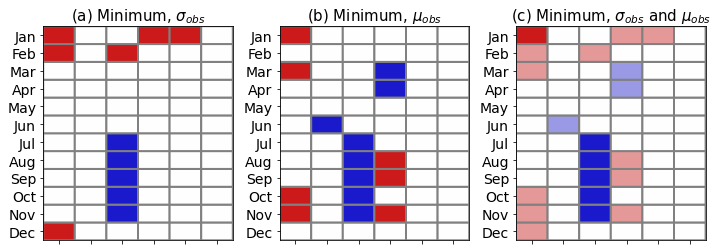

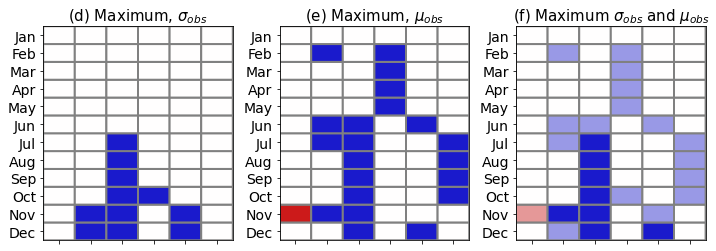

In [6]:
# for obs_data in list(sigma_obs.keys()):
for obs_data in ['CDR', 'HadISST1']:

    #select the dataset for the observations
#     sigma_obs_cons = sigma_obs[obs_data]
#     mu_obs_cons    = mu_obs[obs_data]

#     select minimum or maximum datasets
    if obs_data == 'CDR':
        sigma_obs_cons = sigma_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).min('variable')
        mu_obs_cons    = mu_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).min('variable')
    else:
        sigma_obs_cons = sigma_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).max('variable')
        mu_obs_cons    = mu_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).max('variable')
    
    #calculate which months and models are consistent 
    sigmas = consistent_threshold(sigma_mem_cons, sigma_obs_cons, 0) 
    mus    = consistent_threshold(mu_mem_cons, mu_obs_cons, 0)
    
    #determine red, blue or white with +1, -1, 0
    sigmas_net = sigmas[1] + -1*sigmas[2] #panel (a)
    mus_net    = mus[1] + -1*mus[2] #panel (b)

    both = sigmas_net + mus_net #data for panel (c)
    all_data = [sigmas_net, mus_net, both] #data for (a), (b) and (c) together
    
    if obs_data == 'CDR':
#         titles = ['(a) CDR, $\sigma$', '(b) CDR, $\mu$', '(c) CDR, $\sigma$ and $\mu$']
        titles = ['(a) Minimum, $\sigma_{obs}$', '(b) Minimum, $\mu_{obs}$', '(c) Minimum, $\sigma_{obs}$ and $\mu_{obs}$']
    else:
#         titles = ['(d) HadISST1, $\sigma$', '(e) HadISST1, $\mu$', '(f) HadISST1 $\sigma$ and $\mu$']
        titles = ['(d) Maximum, $\sigma_{obs}$', '(e) Maximum, $\mu_{obs}$', '(f) Maximum $\sigma_{obs}$ and $\mu_{obs}$']
        
        
#     titles = [r'$(a) \ Consistent \ for \ \sigma$', r'$(b) \ Consistent \ for \ \mu$', 
#              r'$(c) \ Consistent \ for \ \sigma \ and \ \mu$']
    cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
    
    #do the plotting
#     fig, ax = plt.subplots(1,3,figsize=[10,6]) 
    fig, ax = plt.subplots(1,3,figsize=[10,3.6]) 

    for i in range(3):
        if i < 2:
            ax[i].pcolor(all_data[i].reindex(month=list(reversed(all_data[i].month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-1, vmax=1)
        else:
            ax[i].pcolor(all_data[i].reindex(month=list(reversed(all_data[i].month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-2, vmax=2)
        ax[i].set_xticks(np.arange(0.5, 5.6, 1));
        ax[i].set_yticks(np.arange(0.5, 11.6, 1));
#         ax[i].set_xticklabels(model_print_names, fontsize=14,rotation = 90);
        ax[i].set_xticklabels(['', '', '', '', '', ''], fontsize=14,rotation = 90);
        ax[i].set_yticklabels(month_names_short.copy()[::-1], fontsize=14);
        ax[i].set_title(titles[i], fontdict={'size':15});#, 'weight':'bold'});

    plt.tight_layout();
#     plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_{}.pdf'.format(obs_data))
#     plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_{}.png'.format(obs_data))
#     if obs_data == 'CDR':
#         plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_min.pdf')
#     else:
#         plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_max.pdf')
#     plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_min_max_no_xlabs.png')

## Consistency for a combination of data sets

In [7]:
#CDR
# sigma_obs_cons = sigma_obs['CDR']
# mu_obs_cons    = mu_obs['CDR']

#minimum sigma_obs
sigma_obs_cons = sigma_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).min('variable')
mu_obs_cons    = mu_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).min('variable')

#calculate which months and models are consistent 
sigmas = consistent_threshold(sigma_mem_cons, sigma_obs_cons, 0) 
mus    = consistent_threshold(mu_mem_cons, mu_obs_cons, 0)

#determine red, blue or white with +1, -1, 0
sigmas_net = sigmas[1] + -1*sigmas[2] #panel (a)
mus_net    = mus[1] + -1*mus[2] #panel (b)

both = sigmas_net + mus_net #data for panel (c)

In [8]:
#HadISST1 
# sigma_obs_cons = sigma_obs['HadISST1']
# mu_obs_cons    = mu_obs['HadISST1']

#maximum sigma_obs
sigma_obs_cons = sigma_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).max('variable')
mu_obs_cons    = mu_obs.to_array().sel(variable=['CDR','BT','NT','HadISST1']).max('variable')

#calculate which months and models are consistent 
sigmas_had = consistent_threshold(sigma_mem_cons, sigma_obs_cons, 0) 
mus_had    = consistent_threshold(mu_mem_cons, mu_obs_cons, 0)

#determine red, blue or white with +1, -1, 0
sigmas_net_had = sigmas_had[1] + -1*sigmas_had[2] #panel (a)
mus_net_had    = mus_had[1] + -1*mus_had[2] #panel (b)

both_had = sigmas_net_had + mus_net_had #data for panel (c)

In [9]:
#agreement
sigmas_net_CDR_Had = sigmas_net.where(sigmas_net==sigmas_net_had) #combined (a)
mus_net_CDR_Had    = mus_net.where(mus_net==mus_net_had) #combined (b)
both_CDR_Had       = both_had.where(np.logical_or(both_had==both, np.logical_and(both_had==1, both==2))) #combined (c)

all_data_CDR_Had = [sigmas_net_CDR_Had, mus_net_CDR_Had, both_CDR_Had] #data for (a), (b) and (c) together

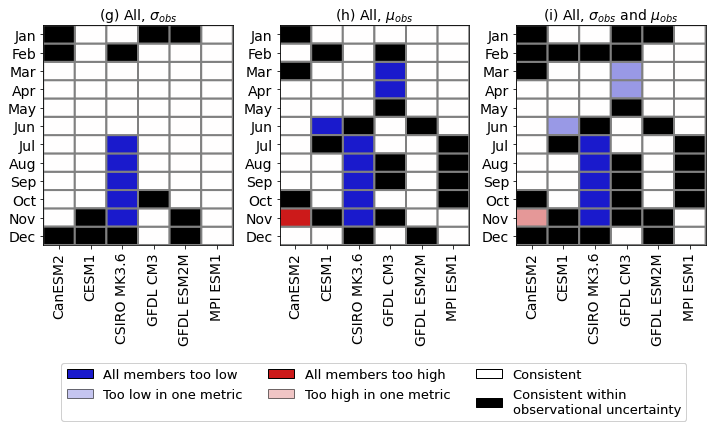

In [11]:
# titles = ['(g) CDR & HadISST1, $\sigma_{obs}$', '(h) CDR & HadISST1, $\mu_{obs}$', 
#           '(i) CDR & HadISST1, $\sigma_{obs}$ and $\mu_{obs}$']
titles = ['(g) All, $\sigma_{obs}$', '(h) All, $\mu_{obs}$', 
          '(i) All, $\sigma_{obs}$ and $\mu_{obs}$']
# cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["blue","1","r"])
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
cmap_gray = mpl.colors.LinearSegmentedColormap.from_list("", ["0","w"])

#do the plotting
fig, ax = plt.subplots(1,3,figsize=[10,5]) 

for i in range(3):
    if i < 2:
        ax[i].pcolor(all_data_CDR_Had[i].reindex(month=list(reversed(all_data_CDR_Had[i].month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-1, vmax=1)
    else:
        ax[i].pcolor(all_data_CDR_Had[i].reindex(month=list(reversed(all_data_CDR_Had[i].month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-2, vmax=2)
    ax[i].pcolor(xr.ufuncs.isnan(all_data_CDR_Had[i]).where(xr.ufuncs.isnan(all_data_CDR_Had[i])==True).reindex(month=list(reversed(both.month))), cmap=cmap_gray, edgecolor='0.5', lw=2)
    ax[i].set_xticks(np.arange(0.5, 5.6, 1));
    ax[i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[i].set_xticklabels(model_print_names, fontsize=14,rotation = 90);
    ax[i].set_yticklabels(month_names_short.copy()[::-1], fontsize=14);
    ax[i].set_title(titles[i], fontdict={'size':14});#, 'weight':'bold'});

legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.6, 0.6, 0.9), ec='0', alpha=0.5, label='Too low in one metric'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor=(0.9, 0.6, 0.6), ec='0', alpha=0.5, label='Too high in one metric'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.75, -0.8), loc='lower center', borderaxespad=0., ncol=3, fontsize=13)

plt.gca().add_artist(extra_legend)    
    
    
plt.tight_layout();
plt.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_2yr_filter_agree.pdf', bbox_inches='tight')
# plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_max_min_agree.png', bbox_inches='tight')

## For poster/talk with only dark red and blue

In [23]:
titles = ['(g) All, $\sigma_{obs}$', '(h) All, $\mu_{obs}$', 
          '(i) All, $\sigma_{obs}$ and $\mu_{obs}$']

cmap = mpl.colors.LinearSegmentedColormap.from_list("", [(0.1, 0.1, 0.8), (0.6, 0.6, 0.9),"1",(0.9, 0.6, 0.6), (0.8, 0.1, 0.1)])
cmap_gray = mpl.colors.LinearSegmentedColormap.from_list("", ["0","w"])

#do the plotting
fig, ax = plt.subplots(1,3,figsize=[10,5]) 

for i in range(3):
    ax[i].pcolor(all_data_CDR_Had[i].reindex(month=list(reversed(all_data_CDR_Had[i].month))), cmap=cmap, edgecolor='0.5', lw=2, vmin=-1, vmax=1)
    ax[i].pcolor(xr.ufuncs.isnan(all_data_CDR_Had[i]).where(xr.ufuncs.isnan(all_data_CDR_Had[i])==True).reindex(month=list(reversed(both.month))), cmap=cmap_gray, edgecolor='0.5', lw=2)
    ax[i].set_xticks(np.arange(0.5, 5.6, 1));
    ax[i].set_yticks(np.arange(0.5, 11.6, 1));
    ax[i].set_xticklabels(model_print_names, fontsize=14,rotation = 90);
    ax[i].set_yticklabels(month_names_short.copy()[::-1], fontsize=14);
    ax[i].set_title(titles[i], fontdict={'size':14});#, 'weight':'bold'});

legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty')]

extra_legend = plt.legend(handles=legend_elements, bbox_to_anchor=(-0.75, -0.8), loc='lower center', borderaxespad=0., ncol=2, fontsize=13)

plt.gca().add_artist(extra_legend)    
    
    
plt.tight_layout();
# plt.savefig(data_path+'SIA/figures/SIA_PDFs_consistency/Consistent_mem_obs_10000_poster.pdf', bbox_inches='tight')